In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

In [4]:
train = pd.read_csv("train.csv")
train.head(1)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/home/chunhui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


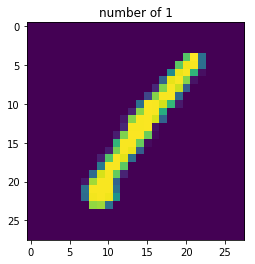

In [11]:
plt.title("number of %d" %train['label'][0])
plt.imshow(train.drop(['label'], axis=1).iloc[0,:].reshape(28,28))

In [13]:
train.shape

(42000, 785)

In [15]:
np.random.seed(1)
idx = np.random.permutation(train.shape[0])
mnist_train = train.iloc[idx[:40000],:]
mnist_validation = train.iloc[idx[40000:],:]

In [47]:
def random_mini_batches(X, Y, batch_size, seed):
    np.random.seed(seed)
    permutation  = np.random.permutation(X.shape[0])
    X = X[permutation,:]
    Y = Y[permutation,:]
    num_batch = int(X.shape[0]/batch_size)
    batches=[]
    for i in range(num_batch):
        mini_X = X[i*batch_size:(i+1)*batch_size,:]
        mini_Y = Y[i*batch_size:(i+1)*batch_size,:]
        batches.append((mini_X, mini_Y))
    if X.shape[0]%batch_size != 0:
        mini_X = X[num_batch*batch_size:,:]
        mini_Y = Y[num_batch*batch_size:,:]
        batches.append((mini_X, mini_Y))
    return batches

In [50]:
def model(data, labels, learning_rate_base=0.003, num_epoch=25000, batch_size=64, L2_lambd=0.0003 ,keep_prob=1.0):
    tf.reset_default_graph()
    #placeholder
    X = tf.placeholder(tf.float32, shape=(None,28,28,1),name="X")
    Y = tf.placeholder(tf.float32, shape=(None,10),name="Y")
    dropout_op = tf.placeholder(tf.float32)
    #froward conv and pool
    W1 = tf.get_variable("W1", shape=(5,5,1,32), initializer=tf.truncated_normal_initializer(stddev=0.1))
    b1 = tf.get_variable("b1", shape=(32), initializer=tf.constant_initializer(0.))
    W2 = tf.get_variable("W2",shape=(5,5,32,64), initializer=tf.truncated_normal_initializer(stddev=0.1))
    b2 = tf.get_variable("b2", shape=(64), initializer=tf.constant_initializer(0.))
    
    conv_1 = tf.nn.conv2d(X, W1, strides=(1,1,1,1), padding="SAME")
    conv_1 = tf.nn.relu(conv_1 + b1)
    pool_1 = tf.nn.max_pool(conv_1, ksize=(1,2,2,1), strides=(1,2,2,1), padding="SAME")
    conv_2 = tf.nn.conv2d(pool_1, W2, strides=(1,1,1,1), padding="SAME")
    conv_2 = tf.nn.relu(conv_2+b2)
    pool_2 = tf.nn.max_pool(conv_2, ksize=(1,2,2,1), strides=(1,2,2,1), padding="SAME")
    #forward fullconnection
    pool_2 = tf.contrib.layers.flatten(pool_2)
    
    W3 = tf.get_variable("W3", shape=(3136, 512), initializer=tf.truncated_normal_initializer(stddev=0.1))
    b3 = tf.get_variable("b3", shape=(1, 512), initializer=tf.constant_initializer(0.1))
    fc_1 = tf.nn.relu(tf.matmul(pool_2, W3) + b3)
    if L2_lambd != 0 :
        loss = tf.contrib.layers.l2_regularizer(L2_lambd)(W3)
        tf.add_to_collection("loss", loss)
    if keep_prob != 0:
        fc_1 = tf.nn.dropout(fc_1, dropout_op)
    
    W4 = tf.get_variable("W4", shape=(512, 10), initializer=tf.truncated_normal_initializer(stddev=0.1))
    b4 = tf.get_variable("b4", shape=(1, 10), initializer=tf.constant_initializer(0.1))
    Z4 = tf.matmul(fc_1, W4) + b4
#     fc_2 = tf.nn.relu(tf.matmul(fc_1, W4) + b4)
    if L2_lambd != 0 :
        loss = tf.contrib.layers.l2_regularizer(L2_lambd)(W4)
        tf.add_to_collection("loss", loss)
#     if keep_prob != 0:
#         fc_2 = tf.nn.dropout(fc_2, dropout_op)
    #compute cost
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z4, labels=Y)) 
    if L2_lambd != 0:
        cost = cost + tf.add_n(tf.get_collection("loss"))
    #train
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(learning_rate_base,
                                              global_step,
                                              data.shape[0]/batch_size,
                                              0.99)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost, global_step = global_step)
    #mini-batch
    input_queue = tf.train.slice_input_producer([data, labels], shuffle=True)
    image_batch, label_batch = tf.train.batch(input_queue, batch_size=batch_size, capacity=64)
    #prediction
    prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Z4, 1))
    accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))
    
    train_cost = []
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        coord=tf.train.Coordinator()
        threads= tf.train.start_queue_runners(sess = sess,coord=coord)
        seed = 0
        for epoch in range(num_epoch):
            #mini batch
            seed = seed+1
            mini_batch_X, mini_batch_Y = sess.run([image_batch, label_batch])
            c, _ = sess.run([cost, optimizer], feed_dict={X: mini_batch_X.reshape(-1,28,28,1), Y: mini_batch_Y, dropout_op:keep_prob})
            
            if epoch % 10 ==0:
                train_cost.append(c/batch_size)
            if epoch%1000 == 0:
                valid_acc = accuracy.eval({X:mnist_validation_images.reshape(-1,28,28,1), Y:mnist_validation_labels, dropout_op:1.0})
                print("%d epoch, validation accuracy: %g" %(epoch, valid_acc))
                print("%d epoch, train cost: %g" %(epoch, c/batch_size))
                print("--------------------------------------------------------")
#         test_acc = accuracy.eval({X:mnist.test.images.reshape(-1,28,28,1), Y:mnist.test.labels.reshape(-1,10), dropout_op:1.0})
        print("%d epoch, test accuracy: %g"%(epoch, test_acc))
        coord.request_stop()
        coord.join(threads)
        plt.plot(np.squeeze(train_cost[0:]))

In [43]:
mnist_validation_images = mnist_validation.drop(['label'], axis=1).values
mnist_validation_labels = pd.get_dummies(mnist_validation['label']).values
mnist_train_images = mnist_train.drop(['label'], axis=1).values
mnist_train_labels = pd.get_dummies(mnist_train['label']).values

In [51]:
model(mnist_train_images, mnist_train_labels)

0 epoch, validation accuracy: 0.9215
0 epoch, train cost: 0.0290604
--------------------------------------------------------


KeyboardInterrupt: 

In [31]:
a=np.array([[1,2,3],[4,5,6],[7,8,9],[9,8,7]])
# a=a.reshape(4,3,1,1)
a

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9],
       [9, 8, 7]])

In [32]:
b=np.array([0,1,2,3])


In [34]:
with tf.Session() as sess:
    coord=tf.train.Coordinator()
    threads= tf.train.start_queue_runners(sess = sess,coord=coord)
    for i in range(4):
        m,n = sess.run([image_batch, label_batch])
        print(m,n)
        print("---------------------------")
    coord.request_stop()
    coord.join(threads)

[[9 8 7]
 [4 5 6]] [3 1]
[[1 2 3]
 [7 8 9]] [0 2]
[[9 8 7]
 [1 2 3]] [3 0]
[[7 8 9]
 [4 5 6]] [2 1]


In [7]:
print(a.shape)
print(b.shape)

(4, 3)
(4,)
